# Cadenced Scheduling in Gurobi

<br>
This notebook will introduce you to a simple scheduling task in which you must determine the optimal means to monitor a list of targets. We will focus on the semester-scale 'top level' of the KPF scheduler, in which we require the monitoring of a list of targets at or near a specified $\textit{cadence}$ (the interval between observations). Let's start by initializing a model.

In [1]:
import gurobipy as gp
from gurobipy import GRB

# Create a new model
Mod = gp.Model("Cadenced Schedule")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-23


Given a list of $n$ targets, we associate a unique identifying number to each, denoted as $t \in T$ where $T = \{0,1,...,n-1\}$ is the total set of targets. Each target has a scaler priority $p_{t}$, and with this model we seek the optimal schedule to maximize the scientific ouput (observations * priority). Each target has a required minimum cadence $c_{t}$ after being observed that must pass before it may be targeted again. In other words, all observations of target $t$ must be at least $c_{t}$ days apart.

In [2]:
#Identifiers for indexing
n = 5
target_ids = range(n)

#Observational priorities
p = [1,2,3,3,2]

#Minimum separation (days)
c = [2,4,7,2,3]

We can set up a simple framework of $m$ slots to schedule observations, with each slot indexed by $s \in S$, where $S = \{0,1,...,m-1\}$. Let's work with 50 consecutive days of observation, and suppose each day permits up to two observations. While simple, this can be easily generalized to larger problems. 

In [3]:
#Number of slots
m = 50

#Identifiers
slots = range(m)

Now we initialize some binary decision variables. For our formulation, we can use decision variables to represent whether targets are being scheduled or not on certain days. The resulting variable is a large matrix, where we can enforce constraints about how many observations are scheduled to each slot, and how many times we observe each target. Let's define the matrix $Y_{ts}$, where $Y_{ts} = 1$ if target $t$ is successfully scheduled to slot $s$, and $Y_{ts} = 0$ otherwise. The result is a large, sparse matrix that we can query later after optimizing, to find what observations correspond to which slots (the nonzero values).

In [4]:
#Initialize multidimensional variables (matrices) by specifying the dimensions (x1,x2,..)
Y = Mod.addVars(target_ids, slots, vtype = GRB.BINARY, name = 'Y')

### Optimizing Sampling
Turning our cadence minimums for each target into LP constraints requires that we enforce relationships between decision variable indeces of $Y$ evaluated at different times. We need to start by creating a set of rules the schedule must follow, assuming that it chooses to schedule an observation at some given time. If the schedule contains an observation of a given target on a given day, we need to prevent observations of the same target on subsequent days until the cadence minimum $c_{t}$ has passed. For each target $t$, and each slot $s$, we define $S'_{t,s}$ to be the list of slots indexed by $\sigma$, which are less than $c_{t}$ slots from $s$ in the future. In other words, $Y_{s,\sigma}$ violates our cadence requirement, should $Y_{t,s}$ be scheduled.

We limit the scheduling of both variables using the expression:
<br>
<center>$1  \ge Y_{t,s} + Y_{t,\sigma} \quad \forall \sigma \in S'_{t,s}$</center>
<br>
This is the LP equivalent to a logical $\textit{or}$ constraint. It enforces that the sum of the assigned values to these variables must not exceed one, meaning $Y_{t,s}$ and $Y_{t,\sigma}$ can never be equal to 1 at the same time. The real-world statement is 'both slots need not be scheduled at the same time, but if one is scheduled, the other must never be'. This constraint is applied to all the slots $\sigma$ in $S'$. 

For example, lets say we're considering slot $s=2$ (the third day) and for our target of consideration $c_{t}=4$. $T'$ would then contain the slots 3, 4, and 5, since these slots are less than four days past the date of consideration. If we observe on $s=2$, then we may not observe this target again until at least $s=6$.  Let's now construct $S'_{t,s}$.

In [5]:
from collections import defaultdict
import numpy as np

#Create a list of dictionaries for each target
#Each dictionary will map a date of observation to the inaccessible dates in T'
S_prime = []
for t in target_ids:
    targ_dict = defaultdict(list)
    min_sep = c[t]
    for s in slots:
        for sigma in slots:
            #Use 'greater than' to avoid  
            if sigma > s and np.abs(sigma - s) < min_sep:
                targ_dict[s].append(sigma)
    S_prime.append(targ_dict)

### Constraints
Now we can enforce the constraints that define our formulation. We want to limit the number of observations that can be scheduled per day to two, and enforce our minimum cadence requirement.

In our LP model, constraining the number of total observations per day is achieved by constraining the sum of our decision matrix $Y_{ts}$ along the $t$ axis. The sum of all the values in each column $s$ should be less than two, in other words only up to two targets can have observations scheduled within any given value of $s$:

<br>
<center>$2  \ge  \sum \limits_{t \in T} Y_{ts} \quad \forall s \in S$</center>
<br>

For example, if targets 2 and 3 are assigned to the first night ($Y_{2,0} = Y_{3,0} = 1$) then the summation for the time index s=0 is already at maximum capacity. No other target $t \in T \setminus \{ 2,3 \}$ can have $Y_{t,0}$ equal to 1. This sets the observational capacity constraint, and ensures we don't overfill any given night with targets.


Programmatically, the cadence constraint is applied in the way we described before.

In [6]:
#Two per slot (night)
constr_two_targs = Mod.addConstrs((Y.sum('*',s) <= 2 for s in slots), 'constr_two_targs')

#Prevent scheduling to slots in T' for each target
for t in target_ids:
    for s in slots:
        #Retrieve marked slots, and constrain each
        invalid_slots = S_prime[t][s]
        Mod.addConstrs(((1 >= Y[t,s] + Y[t,sigma]) for sigma in invalid_slots),
                       'constr_cadence_{}_{}'.format(t,s))

### Objective
Now we need to set the objective. We'll assume our goal is to maximize the number of observed targets times their respective priorities, and then calculate the schedule. Our objective will look like:

<br>
<center>$Maximize(\sum \limits_{t \in T} \sum \limits_{s \in S} p_{t} Y_{ts})$</center>
<br>

And the solver will find optimal values to assign to each index in $Y_{ts}$ that maximizes the value of this objective, subject to the constraints on observations per night and cadence enforcement. It's important to note that since we've chosen to maximize $\textit{priority}$ observations and not just the $\textit{total}$ number of observations to make the solver work a bit harder, the optimal model may not be the one that globally minimizes downtime. If you wanted to weight all the observations equally, you would maximize the nonzero values of $Y_{ts}$ (omit the inclusion of $p_{t}$ in the objective in this case).

In [7]:
#Assign objective function: maximize priority times observations
Mod.setObjective(gp.quicksum(p[r]*Y[r,t] for r in target_ids for t in slots), GRB.MAXIMIZE)

Mod.update()
Mod.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 668 rows, 250 columns and 1486 nonzeros
Model fingerprint: 0x02d93ed4
Variable types: 0 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 171.0000000
Presolve removed 381 rows and 0 columns
Presolve time: 0.01s
Presolved: 287 rows, 250 columns, 1086 nonzeros
Variable types: 0 continuous, 250 integer (250 binary)
Found heuristic solution: objective 172.0000000

Root relaxation: objective 1.808571e+02, 593 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



### Gurobi Output
After our time limit ends, the optimization will halt. The best possible solution found will be assigned to the model variable at that time. Let's examine the ouput in detail, line by line.

```
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
```
These lines specify the version of Gurobi used to optimize the model, and the number of threads utilized by the solver/in your machine. If you've made any changes to the parameters that control the solver, they will appear here. Gurobipy allows you to access and alter these parameters through the API as well, see https://www.gurobi.com/documentation/10.0/refman/parameters.html
```
Optimize a model with 718 rows, 250 columns and 1736 nonzeros
```
This output details the model shape that has been built using Gurobipy. The number of columns is equal to the number of variables (here the total size of $Y$). The number of rows in your model corresponds to the number of constraints that have been added. The coefficients of variable indeces in each constraint form the total constraint matrix, often called $A$. For most constraints, only a few variables are involved, so $A$ is almost always sparse. The LP problem then takes the form $Ax \le b$, where $x$ is a flattened vector of $Y$, and $b$ is specified row by row by our constraints.
```
Variable types: 0 continuous, 250 integer (250 binary)
```
The above section specifies the types of variables within the model (Binary, Continuous, or Integer)
```
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
```
This output gives numerical data on the constraint matrix (ranges of coefficients and objective bounds)
```
Found heuristic solution: objective 171.0000000
Presolve removed 431 rows and 0 columns
Presolve time: 0.00s
Presolved: 287 rows, 250 columns, 1086 nonzeros
Variable types: 0 continuous, 250 integer (250 binary)
Found heuristic solution: objective 172.0000000
```
The next section details the presolve process executed by the optimizer. The presolve process takes the current model, and if possible, will reduce it to a smaller model before executing the full simplex algorithm. 
```
Root relaxation: objective 1.808571e+02, 519 iterations, 0.02 seconds (0.00 work units)
```
Next is a brief message detailing that a maximal upper bound on the objective has been found using the simplex solver (this is done quickly for most models). This is found by first assuming that the variables can all take continuous values, then 'relaxing' to the nearest solution that satisfies your variable bounds (binary in this case). This relaxation is detailed in the next section.
```
        Nodes    |    Current Node    |     Objective Bounds      |     Work
     Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

         0     0  180.85714    0  106  172.00000  180.85714  5.15%     -    0s
    H    0     0                     174.0000000  180.42857  3.69%     -    0s
...
```
The largest section is the logging for the 'branch and cut' search for the optimal solution of the objective. The solver evaluates different paths along each dimension and finds what variable assignments maximize the objective. Columns printed in this step provide detailed information about the solving progress. Important takeaways are the Incumbent and BestBd columns. The Incumbent column gives the objective of the current solution that satisfies the variable bounds. The BestBd is the highest possible objective of all solutions remaining in the 'tree' of remaining possibilities. When these objectives become equal, optimality has been achieved and solving terminates.
```
Solution count 5: 176 175 174 ... 171
Optimal solution found (tolerance 1.00e-04)
Best objective 1.760000000000e+02, best bound 1.760000000000e+02, gap 0.0000%
```
The remaining lines detail solution statistics. This includes the number of solutions found and their relative objectives. The final line tells us how close our objective was to the highest possible (since we reached optimality, these are equal).

In [8]:
#Query the solved parameters
scheduled_targets = defaultdict(list)
for v in Y.values():
    
    #Values retrieved from Model object often encounter precision errors, round to integer
    if np.round(v.X,0) == 1:
        indeces = v.VarName[2:][:-1].split(',')
        
        #Keys are dates/slots, values are targets assigned to that key
        scheduled_targets[int(indeces[1])].append(int(indeces[0]))

Now, we can plot our results based upon the slots assigned by the optimization. Each day will be filled with colors corresponding to the observed targets' indeces. This makes it easy to visualize how closely targets are being observed to their minimum desired cadence.

Text(0.5, 1.0, 'Visualizing 50 Days of Scheduling')

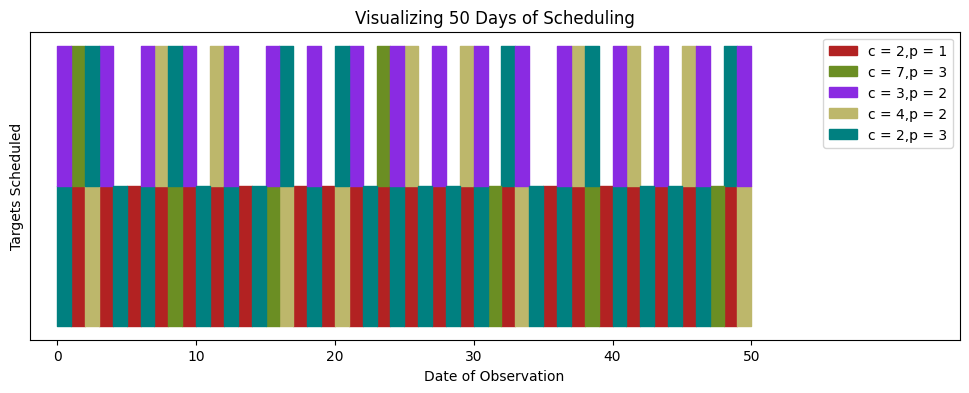

In [9]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,figsize=(12,4))
axs.set_xlim(-2,65)

#Unique colors for each target
target_colors = ['firebrick','darkkhaki','olivedrab','teal','blueviolet']

for day in scheduled_targets.keys():
    axs.fill_between([day,day+1],0,.5,color=target_colors[scheduled_targets[day][0]],
                     label='c = {},p = {}'.format(c[scheduled_targets[day][0]],p[scheduled_targets[day][0]]))
    if len(scheduled_targets[day]) == 2:
        axs.fill_between([day,day+1],.5,1,color=target_colors[scheduled_targets[day][1]],
                        label='c = {},p = {}'.format(c[scheduled_targets[day][1]],p[scheduled_targets[day][1]]))
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

axs.set_yticks([])
axs.set_xticks([0,10,20,30,40,50])
axs.set_xlabel('Date of Observation')
axs.set_ylabel('Targets Scheduled')
axs.set_title('Visualizing 50 Days of Scheduling')

Notice that optimal or near optimal cadence is achieved throughout the entire observing run! Larger breaks between observations are rarely scheduled, and only when it would greatly benefit the solution as a whole. Planning a large semester schedule is built upon these foundations.

## Other Model Archetypes
#### Maximizing the number of observations
Let's visualize the model that has no priority included in the objective and minimizes the downtime of our 'observatory'